### Предварительно нужно
1) склонировать репозиторий командой git clone
2) положить данные (mokrous_300_shots_IEEE.sgy и test_fbpicking_mokrous3d.txt в папку example)
3) перейти в example и запустить этот блокнот

### Удаляем всякие старые данные

In [1]:
!rm -rf data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/
!rm -rf data/raw/dataset1/test_ovch_by_rln_4ms_trimmed/
!rm -rf ./data/raw/dataset1/numpy_splited/
!rm -rf ./data/preprocessed/dataset1/train/
!rm -rf ./data/preprocessed/dataset1/test/
!rm -rf first_break_picking/example/data/raw/dataset1/numpy_splited/

#### Копируем данные в текущую папку (если уже скопировали данные сразу - не нужно)

In [2]:
! cp ../../mokrous_300_shots_IEEE_10-40Hz.sgy .
! cp ../../mokrous_300_shots_IEEE.sgy .
! cp ../../test_fbpicking_mokrous3d.txt .

#### Устанавливаем все, чтобы заработало в блокноте

In [22]:

! pip install segyio
! pip install matplotlib
! pip install ipympl
! jupyter labextension install @jupyter-widgets/jupyterlab-manager
! jupyter labextension install jupyter-matplotlib
! jupyter lab build
! pip install scipy
! pip install -e ..

(Deprecated) Installing extensions with the jupyter labextension install command is now deprecated and will be removed in a future major version of JupyterLab.

Users should manage prebuilt extensions with package managers like pip and conda, and extension authors are encouraged to distribute their extensions as prebuilt packages 
/usr/local/lib/python3.10/dist-packages/jupyterlab/debuglog.py:54: UserWarning: An error occurred.
  warnings.warn("An error occurred.")
/usr/local/lib/python3.10/dist-packages/jupyterlab/debuglog.py:55: UserWarning: ValueError: Please install Node.js and npm before continuing installation. You may be able to install Node.js from your package manager, from conda, or directly from the Node.js website (https://nodejs.org).
  warnings.warn(msg[-1].strip())
/usr/local/lib/python3.10/dist-packages/jupyterlab/debuglog.py:56: UserWarning: See the log file for details: /tmp/jupyterlab-debug-7wju_uil.log
  warnings.warn(f"See the log file for details: {log_path!s}")
(

### Начинаем подготовку данных

##### Сюда вписать название файла с данными

In [ ]:
file_path = r'/Users/aleksei/jupyters/mokrous_300_shots_IEEE.sgy'

In [2]:
import sys
import os.path as osp
from pathlib import Path
import shutil
import os
import segyio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
def AGC(data, window_length):
    """
    Функция для автоматической регулировки усиления (AGC).
    
    Аргументы:
    - data: двумерный массив (сейсмическая сейсмограмма).
    - window_length: размер окна для вычисления среднего значения энергии.

    Возвращает:
    - data_agc: данные после применения AGC.
    """
    data = data.T
    # Длины данных
    n_traces, n_samples = data.shape
    data_agc = np.zeros_like(data)

    # Цикл по трассам
    for trace_idx in range(n_traces):        
        trace = data[trace_idx]
        # Вычисляем энергию в скользящем окне
        envelope = np.convolve(np.abs(trace), np.ones(window_length), mode='same') / window_length
        # Избегаем деления на 0, добавляем небольшой сдвиг
        envelope[envelope == 0] = 1e-10
        # Усиление сигнала (нормализация)
        data_agc[trace_idx] = trace / envelope
    
    return data_agc.T

In [4]:
def read_and_split_segy(file_path: str, header1: str, header2: str, output_dir: str, split_nt: int) -> dict:
    """Читает сейсмограмму из файла SEGY, разбивает её по указанным заголовкам (header1, header2)
    и экспортирует подсейсмограммы в .npy файлы.

    Parameters
    ----------
    file_path : str
        Путь к файлу SEGY.
    header1 : str
        Первый заголовок, по которому будет происходить разбивка.
    header2 : str
        Второй заголовок, по которому будет происходить разбивка.
    output_dir : str
        Папка, куда будут сохранены .npy файлы.

    Returns
    -------
    dict
        Словарь сейсмограмм, разбитых по значениям указанных заголовков.
    """
    split_seismograms = {}

    with segyio.open(file_path, ignore_geometry=True) as segy_file:
        # Получаем количество следов
        num_traces = segy_file.tracecount
        # Создаем массив для хранения данных
        data = np.zeros((num_traces, len(segy_file.samples)))
        print(data.shape)
        # Чтение данных каждого следа
        for i in range(num_traces):
            data[i] = segy_file.trace[i]

        # # Визуализируем оригинальную сейсмограмму
        # plt.figure(figsize=(10, 6))
        # plt.imshow(data.T, aspect='auto', cmap='gray')
        # plt.title('Original Seismogram')
        # plt.xlabel('Trace Number')
        # plt.ylabel('Sample Number')
        # plt.colorbar(label='Amplitude')
        # plt.show()

        # Получаем значения атрибутов для двух заголовков
        try:
            field1 = getattr(segyio.TraceField, header1)
            field2 = getattr(segyio.TraceField, header2)
        except AttributeError as e:
            raise ValueError(f"Указанный заголовок '{e.args[0]}' отсутствует в TraceField.")

        attributes1 = segy_file.attributes(field1)[:]
        attributes2 = segy_file.attributes(field2)[:]

        # Группируем сейсмограммы по значениям двух заголовков
        for i in tqdm(range(num_traces)):
            header1_value = int(attributes1[i])  # Преобразуем значение первого заголовка в int
            header2_value = int(attributes2[i])  # Преобразуем значение второго заголовка в int
            key = (header1_value, header2_value)  # Используем кортеж в качестве ключа

            if key not in split_seismograms:
                split_seismograms[key] = []

            split_seismograms[key].append(data[i])  # Добавляем трассы без транспонирования

        for key, value in tqdm(split_seismograms.items()):
            split_seismograms[key] = np.array(value).T

    # Транспонируем уже собранные подсейсмограммы
    #transposed_seismograms = {key: value for key, value in split_seismograms.items() if value.shape[1] > split_nt}
    transposed_seismograms = {key: value for key, value in split_seismograms.items() if value.shape[1] == 180}
    
    #transposed_seismograms = {key: np.array(value).T for key, value in split_seismograms.items()}
    
    # Сохраняем в формате .npy
    os.makedirs(output_dir, exist_ok=True)

    for (header1_value, header2_value), value in tqdm(transposed_seismograms.items()):
        #file_name = os.path.join(output_dir, f"seismogram_{header1}_{header1_value}_{header2}_{header2_value}.npy")
        file_name = os.path.join(output_dir, f"{header1_value*1000+header2_value}.npy")
        #print(value.shape)
        # if value.shape[1] != 128:
        #     continue
        np.save(file_name, value)
        #print(f"Сохранено: {file_name}")

    return transposed_seismograms



def save_seismograms_with_headers(seismograms: dict, output_dir: str, header1: str, header2: str):
    """Сохраняет сейсмограммы в формате .npy с указанием значений двух заголовков в названии файла.

    Parameters
    ----------
    seismograms : dict
        Словарь сейсмограмм, где ключами являются кортежи (header1_value, header2_value),
        а значениями — NumPy массивы сейсмограмм.
    output_dir : str
        Путь к выходной директории для сохранения файлов.
    header1 : str
        Название первого заголовка.
    header2 : str
        Название второго заголовка.
    """
    os.makedirs(output_dir, exist_ok=True)  # Создаем директорию, если она не существует

    for (header1_value, header2_value), seismo_data in seismograms.items():
        # Формируем имя файла с учетом заголовков и их значений
        #file_name = f"seismogram_{header1}_{header1_value}_{header2}_{header2_value}.npy"
        file_name = f"{header1_value}{header2_value}.npy"
        file_path = os.path.join(output_dir, file_name)
        print(seismo_data.shape)
        # Сохраняем сейсмограмму в .npy
        np.save(file_path, seismo_data)
        print(f"Сохранено: {file_path}")





def data_normalize_and_limiting(data: np.ndarray) -> np.ndarray:
    """
    Trace based scale a shot

    Parameters
    ----------
    data : np.ndarray
        _description_

    Returns
    -------
    np.ndarray
        _description_
    """
    norma = np.max(np.abs(data), axis=0)
    norma[np.abs(norma) < 1e-9 * np.max(np.abs(norma))] = 1
    data = data / norma * 4
    data[data < -1] = -1
    data[data > 1] = 1
    return data


def trim_npy_files_normalize(input_directory, output_directory, num_samples):
    """
    Читает файлы .npy, обрезает их до заданного количества сэмплов и сохраняет с обновленным названием.
    
    :param input_directory: Папка с исходными .npy файлами
    :param output_directory: Папка, куда сохранять обрезанные файлы
    :param num_samples: Количество сэмплов, до которого необходимо обрезать
    """
    # Убедимся, что директория для сохранения существует
    os.makedirs(output_directory, exist_ok=True)

    # Проход по всем файлам в указанной директории
    for filename in os.listdir(input_directory):
        # Проверяем, является ли файл файлом .npy
        if filename.endswith(".npy"):
            file_path = os.path.join(input_directory, filename)  # Полный путь к файлу
            
            # Загрузка numpy массива
            data = np.load(file_path)
            print(f"Файл загружен. Исходный размер: {data.shape}")
            
            # Проверяем, что обрезка возможна
            if data.shape[0] < num_samples:
                print(f"Пропущен файл {filename}: недостаточно сэмплов ({data.shape[0]}).")
                continue
            
            # Обрезаем массив до заданного количества сэмплов
            trimmed_data = data[:num_samples, :]
            print(f"Размер обрезанного файла: {trimmed_data.shape}")
            
            # Генерируем новое имя файла, добавляя количество сэмплов в название
            base_name = os.path.splitext(filename)[0]
            #new_filename = f"{base_name}_trim_{num_samples}.npy"
            new_filename = f"{base_name}.npy"
            new_file_path = os.path.join(output_directory, new_filename)

            trimmed_data = data_normalize_and_limiting(trimmed_data)
            # Сохраняем обрезанный массив
            np.save(new_file_path, trimmed_data)
            print(f"Обработанный файл сохранён: {new_file_path}\n")

    print("Обрезка всех файлов завершена.")

In [5]:
from config import split_nt

In [6]:

header1_to_split = 'EnergySourcePoint'  # Первый заголовок
header2_to_split = 'GroupStaticCorrection'  # Второй заголовок
output_directory = r'data/raw/dataset1/numpy_splited'  # Папка для сохранения .npy файлов
seismograms = read_and_split_segy(file_path, header1_to_split, header2_to_split, output_directory, split_nt)

(1285440, 1000)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7007/7007 [01:01<00:00, 114.44it/s]


In [9]:
output_diarectory = r'./data/raw/dataset1/numpy_splited'  # Папка для сохранения файлов
header1_to_use = 'NPS'
header2_to_use = 'RLN'

# Сохранение данных:
save_seismograms_with_headers(seismograms, output_directory, header1_to_use, header2_to_use)

(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766009.npy
(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766015.npy
(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766021.npy
(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766027.npy
(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766033.npy
(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766039.npy
(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766045.npy
(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766051.npy
(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766057.npy
(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766063.npy
(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766069.npy
(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766075.npy
(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766081.npy
(1000, 180)
Сохранено: data/raw/dataset1/numpy_splited/249360766

In [10]:
len(os.listdir("./data/raw/dataset1/numpy_splited"))

14014

In [12]:
# Директория с исходными .npy файлами
input_directory = r"./data/raw/dataset1/numpy_splited/"

# Директория для сохранения обрезанных файлов
output_directory = r"./data/raw/dataset1/train_ovch_by_rln_4ms_trimmed"

# Задаём количество сэмплов для обрезки
num_samples = 750  # задайте нужное количество сэмплов

# Запускаем функцию
trim_npy_files_normalize(input_directory, output_directory, num_samples)

Файл загружен. Исходный размер: (1000, 180)
Размер обрезанного файла: (750, 180)
Обработанный файл сохранён: ./data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/24985217187.npy

Файл загружен. Исходный размер: (1000, 180)
Размер обрезанного файла: (750, 180)
Обработанный файл сохранён: ./data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/249961146129.npy

Файл загружен. Исходный размер: (1000, 180)
Размер обрезанного файла: (750, 180)
Обработанный файл сохранён: ./data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/249952925235.npy

Файл загружен. Исходный размер: (1000, 180)
Размер обрезанного файла: (750, 180)
Обработанный файл сохранён: ./data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/24995329373.npy

Файл загружен. Исходный размер: (1000, 180)
Размер обрезанного файла: (750, 180)
Обработанный файл сохранён: ./data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/249960236039.npy

Файл загружен. Исходный размер: (1000, 180)
Размер обрезанного файла: (750, 180)
Обработанный файл сохранён: ./data/r

In [14]:
len(os.listdir("./data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/"))

14014

##### Добавляем готовые пики

In [15]:
import pandas as pd
file_path = "test_fbpicking_mokrous3d.txt"

with open(file_path, "r", encoding="utf-8") as file:
    lines = file.readlines()

with open(file_path, "w", encoding="utf-8") as file:
    file.writelines(line for line in lines if not line.lstrip().startswith("#"))

df = pd.read_csv(file_path, sep='\t', header = None)
df.columns = [x.strip() for x in "itrace  |   NSP |   NRP |   SLN |   RLN |   NTR |   FB_TIME".split("|")]



rln_list = sorted(df.RLN.value_counts().index.tolist())
nps_list = df.NSP.value_counts().index.tolist()
for nps in tqdm(nps_list):
    for rln in rln_list:
        fb_time = df[(df.NSP == nps) & (df.RLN == rln)].set_index('itrace').FB_TIME
        if fb_time.shape[0]:
            npy_path = f'data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/{nps}{int(rln)}.npy'
            txt_path = f'data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/{nps}{int(rln)}.txt'
            # Если файл .npy отсутствует, создаём .txt
            if os.path.exists(npy_path):
                fb_time.rename('Time').to_csv(txt_path, index=False)

            

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:49<00:00,  6.04it/s]


In [16]:
len(os.listdir("./data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/"))

21021

import os
import re
def keep_only_10_pairs(folder_path):
    """
    Функция находит все файлы вида XXXX.npy и XXXX.txt в папке folder_path,
    где XXXX – это некая числовая часть. Скрипт сохраняет только первые
    10 уникальных чисел (по возрастанию), а остальные файлы удаляет.
    """
    # Получаем список всех файлов в папке
    all_files = os.listdir(folder_path)
    
    # Словарь для группировки:
    # Ключ   -> число (int)
    # Значение -> список имён файлов с этим числом
    base_dict = {}
    
    # Регулярное выражение, чтобы извлечь число и расширение
    pattern = re.compile(r'^(\d+)\.(npy|txt)$')
    
    # 1. Проходим по всем файлам в папке
    for filename in all_files:
        match = pattern.match(filename)
        if match:
            # match.group(1) – это сама числовая основа в виде строки
            # match.group(2) – расширение (npy или txt)
            base_num_str = match.group(1)
            base_num = int(base_num_str)
            
            # Сохраняем файл в словарь по ключу base_num
            if base_num not in base_dict:
                base_dict[base_num] = []
            base_dict[base_num].append(filename)
    
    # 2. Сортируем ключи (числа) по возрастанию
    sorted_numbers = sorted(base_dict.keys())
    
    # 3. Берём первые 10 чисел, которые хотим оставить
    numbers_to_keep = sorted_numbers[:30]
    
    # 4. Все остальные числа идут "за пределами" первых 10
    numbers_to_delete = sorted_numbers[30:]
    
    # 5. Удаляем файлы для чисел, которые не вошли в первые 10
    for base_num in numbers_to_delete:
        file_list = base_dict[base_num]
        for file_to_remove in file_list:
            full_path = os.path.join(folder_path, file_to_remove)
            print(f"Удаляю файл: {full_path}")
            os.remove(full_path)

keep_only_10_pairs("data/raw/dataset1/train_ovch_by_rln_4ms_trimmed/")

#### Делим выборку

In [17]:
import re
import os
def move_pairs_by_percentage(source_folder, destination_folder, percentage=0.2):
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        
    files = os.listdir(source_folder)
    pattern = re.compile(r'^(\d+)\.(npy|txt)$')
    groups = {}
    
    for f in files:
        match = pattern.match(f)
        if match:
            num = int(match.group(1))
            if num not in groups:
                groups[num] = []
            groups[num].append(f)
    
    sorted_nums = sorted(groups.keys())
    total_pairs = len(sorted_nums)
    pairs_to_move = int(total_pairs * percentage)
    
    for num in sorted_nums[:pairs_to_move]:
        for fname in groups[num]:
            shutil.move(os.path.join(source_folder, fname),
                        os.path.join(destination_folder, fname))
    
    print(f"Перемещено {pairs_to_move} из {total_pairs} пар.")

move_pairs_by_percentage("data/raw/dataset1/train_ovch_by_rln_4ms_trimmed",
                         "data/raw/dataset1/test_ovch_by_rln_4ms_trimmed", percentage=0.2)


Перемещено 2802 из 14014 пар.


In [18]:
import os
import re
import os
import re

def remove_unpaired_files(folder_path, dry_run=True):
    """
    Finds and removes files that have a .npy version but no corresponding .txt version,
    and vice versa.
    
    Args:
        folder_path: Path to the folder containing the files to check
        dry_run: If True, only reports what would be deleted without actual deletion.
                 Set to False to perform actual deletion.
        
    Returns:
        A tuple containing:
        - Count of files with .npy but no .txt that were deleted
        - List of file numbers with .npy but no .txt that were deleted
        - Count of files with .txt but no .npy that were deleted
        - List of file numbers with .txt but no .npy that were deleted
    """
    # Check if folder exists
    if not os.path.exists(folder_path):
        print(f"Папка {folder_path} не существует.")
        return 0, [], 0, []
    
    # Get all files in the folder
    files = os.listdir(folder_path)
    
    # Create pattern to match file names with number and extension
    pattern = re.compile(r'^(\d+)\.(npy|txt)$')
    
    # Dictionaries to track which numbers have which file types
    npy_files = {}
    txt_files = {}
    
    # Sort files into appropriate dictionaries
    for file in files:
        match = pattern.match(file)
        if match:
            num = int(match.group(1))
            ext = match.group(2)
            
            if ext == 'npy':
                npy_files[num] = file
            elif ext == 'txt':
                txt_files[num] = file
    
    # Find files with .npy but no .txt
    npy_only = [num for num in npy_files if num not in txt_files]
    npy_only_count = len(npy_only)
    
    # Find files with .txt but no .npy
    txt_only = [num for num in txt_files if num not in npy_files]
    txt_only_count = len(txt_only)
    
    # Process the unpaired files
    deleted_npy = []
    deleted_txt = []
    
    # Print and delete .npy files without corresponding .txt
    #print(f"Файлы с .npy но без .txt ({npy_only_count}):")
    for num in sorted(npy_only):
        file_path = os.path.join(folder_path, npy_files[num])
        #print(f"  {npy_files[num]}")
        
        if not dry_run:
            try:
                os.remove(file_path)
                deleted_npy.append(npy_files[num])
                #print(f"    Удален: {npy_files[num]}")
            except Exception as e:
                print(f"    Ошибка при удалении {npy_files[num]}: {e}")
    
    # Print and delete .txt files without corresponding .npy
    #print(f"\nФайлы с .txt но без .npy ({txt_only_count}):")
    for num in sorted(txt_only):
        file_path = os.path.join(folder_path, txt_files[num])
        #print(f"  {txt_files[num]}")
        
        if not dry_run:
            try:
                os.remove(file_path)
                deleted_txt.append(txt_files[num])
                #print(f"    Удален: {txt_files[num]}")
            except Exception as e:
                print(f"    Ошибка при удалении {txt_files[num]}: {e}")
    
    # Summary of actions
    if not dry_run:
        print(f"\nВсего удалено:")
        print(f"  {len(deleted_npy)} файлов .npy без соответствующих .txt")
        print(f"  {len(deleted_txt)} файлов .txt без соответствующих .npy")
    else:
        print("\nЭто был режим тестирования (dry run). Файлы не были удалены.")
        print("Для удаления файлов вызовите функцию с параметром dry_run=False")
    
    return len(deleted_npy), deleted_npy, len(deleted_txt), deleted_txt

# Example usage
# rem1ove_unpaired_files('/path/to/your/folder', dry_run=True)  # Just report
# remove_unpaired_files('/path/to/your/folder', dry_run=False)  # Actually delete
# Example usage
_ = remove_unpaired_files('data/raw/dataset1/train_ovch_by_rln_4ms_trimmed', dry_run=False)
#_ = remove_unpaired_files("data/raw/dataset1/test_ovch_by_rln_4ms_trimmed", dry_run=False)



Всего удалено:
  4205 файлов .npy без соответствующих .txt
  0 файлов .txt без соответствующих .npy


In [19]:
1

1

#### Перекладываем данные в формат либы

In [20]:
! rm -rf ./data/preprocessed/dataset1/train/

In [21]:
#%% ========== Loading required packages 
import sys
import os.path as osp
from pathlib import Path
import shutil


from first_break_picking.data import save_shots_fb
from first_break_picking import predict



from config import  (split_nt,
                     overlap,
                     dt,
                     n_time_sampels,
                     upsampled_size,
                     num_epcohs,
                     )
#%% ============ Define paths ===============
project_path = '.'
data_base_train = project_path + "/data/"

# Define all data files for picking
raw_data_path = data_base_train + "raw/dataset1/train_ovch_by_rln_4ms_trimmed/"

preprocessed_path = f"{data_base_train}/preprocessed/dataset1/train"

# Path(path_to_save).mkdir(exist_ok=True, parents=True)
Path(preprocessed_path).mkdir(exist_ok=True, parents=True)
#%% =================== Prepare data =============
data_info = save_shots_fb(
        dataset_dir=raw_data_path,
        dir_to_save=preprocessed_path,
        split_nt= split_nt,
        overlap = overlap,
        time_window=[0, n_time_sampels],
        fbt_file_header=1,
        fbt_time_column=0,
        scale=True,
        grayscale=True,
        dt=dt,
        shot_ext=".npy",
        fb_ext=".txt"
        )
    
# %% ======== Show results ===========
checkpoint_path = project_path + f"/checkpoints/chp_fb_{num_epcohs}.tar"
print(f"checkpoint is loaded: {checkpoint_path}")



/Users/aleksei/first_pick_test/first_break_picking/first_break_picking/data/data_utils.py:646: RuntimeWarning: invalid value encountered in true_divide
  data = 255 * (nom/ denom + 0.5)
/Users/aleksei/first_pick_test/first_break_picking/first_break_picking/data/data_utils.py:646: RuntimeWarning: invalid value encountered in true_divide
  data = 255 * (nom/ denom + 0.5)
/Users/aleksei/first_pick_test/first_break_picking/first_break_picking/data/data_utils.py:646: RuntimeWarning: invalid value encountered in true_divide
  data = 255 * (nom/ denom + 0.5)
/Users/aleksei/first_pick_test/first_break_picking/first_break_picking/data/data_utils.py:646: RuntimeWarning: invalid value encountered in true_divide
  data = 255 * (nom/ denom + 0.5)
/Users/aleksei/first_pick_test/first_break_picking/first_break_picking/data/data_utils.py:646: RuntimeWarning: invalid value encountered in true_divide
  data = 255 * (nom/ denom + 0.5)
/Users/aleksei/first_pick_test/first_break_picking/first_break_picking

checkpoint is loaded: ./checkpoints/chp_fb_2.tar


/Users/aleksei/first_pick_test/first_break_picking/first_break_picking/data/data_utils.py:646: RuntimeWarning: invalid value encountered in true_divide
  data = 255 * (nom/ denom + 0.5)
/Users/aleksei/first_pick_test/first_break_picking/first_break_picking/data/data_utils.py:646: RuntimeWarning: invalid value encountered in true_divide
  data = 255 * (nom/ denom + 0.5)


In [22]:
1

1

### Обучаем

In [1]:
!rm -rf ./data//preprocessed/dataset1/train/.ipynb_checkpoints

In [2]:
%matplotlib widget

In [3]:
project_path = '.'
data_base_train = project_path + "/data/"

# Define all data files for picking
raw_data_path = data_base_train + "raw/dataset1/train_ovch_by_rln_4ms_trimmed/"

preprocessed_path = f"{data_base_train}/preprocessed/dataset1/train"

In [4]:
#%% ========== Loading required packages 
import pandas as pd
import os.path as osp
import matplotlib.pyplot as plt
from time import time
from pathlib import Path
import shutil
from matplotlib.ticker import MaxNLocator
# import sys
# sys.path.append(osp.abspath(osp.join(__file__, "../../")))
from first_break_picking import train
from first_break_picking.tools import seed_everything
from first_break_picking.data import save_shots_fb

from config import  (split_nt,
                     overlap,
                     dt,
                     n_time_sampels,
                     upsampled_size,
                     batch_size,
                     val_percentage,
                     num_epcohs,
                     step_size_milestone
                     )

In [5]:
num_epcohs, batch_size

(3, 30)

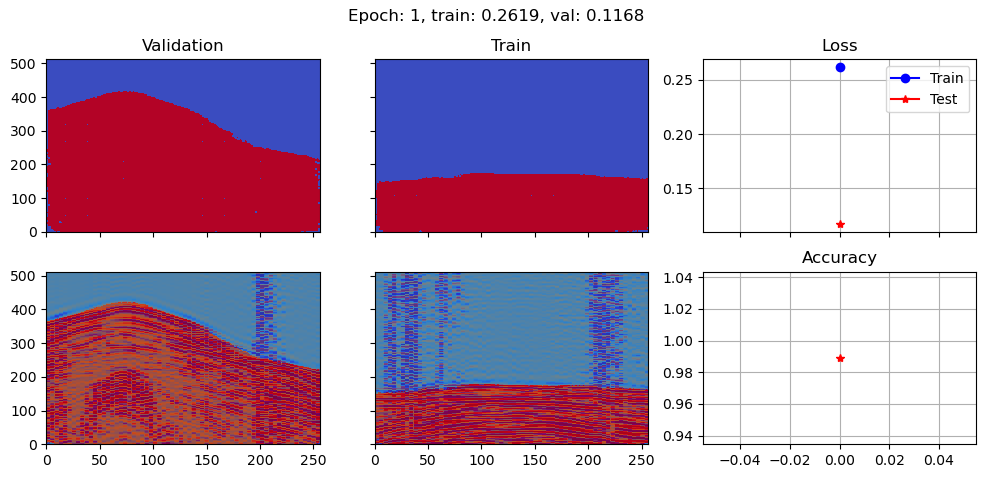

Epoch 1: 
train loss: 0.26186442606573884 
validation loss: 0.11676866561174393



  1%|▉                                                                                                                                   | 21/2943 [00:25<58:10,  1.19s/it, loss=0.116]

In [ ]:
#%% =================== Training =================
tic = time()
train(preprocessed_path, 
    upsampled_size_row=n_time_sampels,
    upsampled_size_col=upsampled_size,
    batch_size=batch_size, 
    val_percentage=val_percentage,
    epochs=num_epcohs, 
    learning_rate=1e-6, 
    type_of_problem="fb",
    #device="mps",
    #sdevice="cuda",
    device="cpu",
    checkpoint_path=None,
    path_to_save= project_path,
    save_frequency=num_epcohs,
    show=True,
    step_size_milestone=step_size_milestone
    )
toc = time()
print(f"It took {toc - tic} s for {num_epcohs} epochs")

# %% ============= plot metrics =================
metrics_path = f"{project_path}/checkpoints/metrics_fb.csv"
metrics = pd.read_csv(metrics_path)
    
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(121)
ax.plot(metrics.train_loss, label="Training set", 
    color="k")
ax.plot(metrics.valid_loss, linestyle="--",
     color="k", label="Validation set", linewidth=3
     )
ax.grid()
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.legend()

ax = fig.add_subplot(122)
ax.plot(metrics.pixel_accuracy, label="Pixel",
    color="k")
ax.set_ylabel("Validation Accuracy")
ax.set_xlabel("Epoch")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.grid()

#shutil.rmtree(f"{data_base_train}/preprocessed")
plt.show()


In [ ]:
! cp checkpoints/chp_fb_3.tar ./chp_fb_3_bad_data_1e6_bs30.tar